In [1]:
#if doing multiple convolution layers, do them all at the beginning first, then flatten out the layers and then
#apply either one or multiple fully connected layers - if we do multiple fully connected layers, then each layer will have 
#different weights and non-linear functions (the more fully connected layers the more non-linear we go)
#for now we can expect ReLu to be fine and if not will alter from there

In [1]:
import os
from os.path import exists, isfile, join
gpu = 'O'
os.environ['KERAS_BACKEND']        = "tensorflow"
os.environ['CUDA_VISIBLE_DEVICES'] = gpu
#THE GPU IS SET UP HERE

In [3]:
import tensorflow as tf
print ('Using Tensorflow version: ', tf.__version__)
import keras
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.activations import *
#from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from train_utils import read_config, get_patch_size, count_events#, load_config

import numpy as np
np.random.seed(2021)  # for reproducibility
import json #stands for java script object notation
import math
import datetime

Using Tensorflow version:  2.10.0


In [4]:
def save_model(model, name):
    try:
        name += '_'
        name += datetime.datetime.now().strftime("%y%m%d-%H:%M")
        with open(name + '_architecture.json', 'w') as f:
            f.write(model.to_json())
        # model.save_weights(name + '_weights.h5', overwrite=True)
        return True
    except: return False

def save_history(history, name):
    try:
        name += '_'
        name += datetime.datetime.now().strftime("%y%m%d-%H:%M")
        name += '.npy'
        np.save(name, history.history)
        return True
    except: return False

In [5]:
config = read_config("train_config.json")
#config = load_config("train_config.json", allow_pickle = True)
print(config) #note to self: folder 0 is the one I tried making multiple files combined

INPUT_DIR = config['input_dir']

#print("input dir:", INPUT_DIR) #gives the following when printed: input dir: /home/kmream/mlfile/tutorial
PATCH_SIZE_W, PATCH_SIZE_D = 2400,80

{'input_dir': '/home/kmream/mlfile/tutorial/samples/test/samples_', 'batch_size': 10, 'nb_epoch': 10}


In [6]:
FRACTION_VALIDATION = 0.1
FRACTION_TEST       = 0.1
BATCH_SIZE          = config['batch_size']
N_EPOCH             = config['nb_epoch']

N_CONV_FILTERS_0 = 40 #number of kernels
N_CONV_FILTERS_1 = 80 #number of kernels
N_CONV_FILTERS_2 = 120 #number of kernels
CONV_SHAPES    = [3] #size of nxn kernel
CONV_ACT_FN    = 'LeakyReLu'
DROPOUT1       = 0.5 #amount of pixels that drop out, in this case 50%
DROPOUT2       = 0.3

DENSESIZE1   = 64 #values given in the code, will most likely mess around with these
DENS_ACT_FN1 = 'LeakyReLu'

DENSESIZE2   = 32 #values given in the code, will most likely mess around with these
DENS_ACT_FN2 = 'LeakyReLu'

In [7]:
# N_CONV_LAYERS0 = len(N_CONV_FILTERS_0)
# N_CONV_LAYERS1 = len(N_CONV_FILTERS_1)
# N_CONV_LAYERS2 = len(N_CONV_FILTERS_2)
# #N_CONV_LAYERS = [[1],[1],[1]]
# #print(N_CONV_LAYERS[2])
# #print("N_Conv_Layers:", N_CONV_LAYERS) #printing this out it's only 1? need to resolve this issue or rewrite it since in the ex code it only takes in one conv layer
N_CONV_LAYERS0 = [N_CONV_FILTERS_0]
CONFIG_NAME  = str(N_CONV_LAYERS0) + 'layers_' + CONV_ACT_FN + '_' + str(N_EPOCH) + '_epoch'

# datestring = datetime.datetime.now().strftime("%y%m%d-%h:%m")
# if len(N_CONV_FILTERS_0) != len(CONV_SHAPES): 
#     print ("Invalid conv filters")
#     exit()
# if len(N_CONV_FILTERS_1) != len(CONV_SHAPES): 
#     print ("Invalid conv filters")
#     exit()
# if len(N_CONV_FILTERS_2) != len(CONV_SHAPES): 
#     print ("Invalid conv filters")
#     exit()

In [10]:
#different kernel initializers to try out (mark if tried already):
#Zeros
#Ones
#RandomNormal: initializes on gaussian distribution of specified mean and std
#RandomUniform: initializes on uniform range of specified range
#GlorotNormal: initializes on gaussian distribution
#GlorotUniform: initializes on uniform distribution for activation functions
#HeNormal: initializes on gaussian with variance scaling on number of inputs
#HeUniform: initializes on uniform range scaling on number of inputs
#Orthogonal: initializes as a random matrix
#Identity: initializes as identity matrix
#VarianceScaling: specify custom scaling functions for weights

In [12]:
#creating the UNet model
def unet_model(input_shape):
    #we note that since dealing wiht grayscale images there is only a single channel, so no need to bother with starting neurons 
    main_input = Input(shape=input_shape, name='main_input') #sparse=True, name='main_input')

    conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same')(main_input)
    act1 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(act1)
    drop1 = Dropout(0.5)(pool1)

    conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same')(pool1)
    act2 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(act2)
    drop2 = Dropout(0.5)(pool2)

    conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same')(pool2)
    act3 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(act3)
    drop3 = Dropout(0.5)(pool3)

    conv4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same')(pool3)
    act4 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(act4)
    drop4 = Dropout(0.5)(pool4)
    
    convm = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same')(pool4)
    actm = tf.keras.layers.LeakyReLU(alpha=0.01)(convm)
    dropm = Dropout(0.5)(actm)
    convm2 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same')(dropm)
    actm2 = tf.keras.layers.LeakyReLU(alpha=0.01)(convm2)
    dropm2 = Dropout(0.5)(actm2)
    convm3 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same')(dropm2)
    actm3 = tf.keras.layers.LeakyReLU(alpha=0.01)(convm3)
    dropm3 = Dropout(0.5)(actm3)
    convm4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same')(dropm3)
    actm4 = tf.keras.layers.LeakyReLU(alpha=0.01)(convm4)
    dropm4 = Dropout(0.5)(actm4)
    #middle convolution
    
    # Expanding Path (Decoder) activation='leakyrelu',
    conv5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same')(dropm4)
    act5 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv5)
    up1 = tf.keras.layers.UpSampling2D(size=(2, 2))(act5)
    merge1 = tf.keras.layers.Concatenate(axis=-1)([conv4, up1])

    conv6 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same')(merge1)
    act6 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv6)
    up2 = tf.keras.layers.UpSampling2D(size=(2, 2))(act6)
    merge2 = tf.keras.layers.Concatenate(axis=-1)([conv3, up2])

    conv7 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same')(merge2)
    act7 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv7)
    up3 = tf.keras.layers.UpSampling2D(size=(2, 2))(act7)
    merge3 = tf.keras.layers.Concatenate(axis=-1)([conv2, up3])
    
    conv8 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same')(merge3)
    act8 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv8)
    up4 = tf.keras.layers.UpSampling2D(size=(2, 2))(act8)
    merge4 = tf.keras.layers.Concatenate(axis=-1)([conv1, up4])
    
    #figure out a way to let the network know that I'm taking the mean of the image value
    #modeltest_mean = np.mean(modeltest, axis=(1, 2))  # Take the mean along height and width axes
    #modeltest_mean = np.squeeze(modeltest_mean)
    
    flatten = tf.keras.layers.Flatten()(merge4)

    #output = tf.keras.layers.Conv2D(filters=1, kernel_size=1, activation='linear', name='output')(dense)
    #output = tf.keras.layers.Dense(1, activation='linear', name='output')(dense)
    output = tf.keras.layers.Dense(1, activation= 'linear', name = 'output')(flatten)
    
    #michel = Dense(1, activation='sigmoid', name='michel_netout')(x)
    
    #optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.8) #not 1e-6, not 1e-4
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6, beta_1=0.8)
    
    model = Model(inputs=[main_input], outputs=[output]) #possibly do x as output
    model.compile(optimizer=optimizer, loss={'output':'mean_squared_error'})#, metrics=['mean_absolute_error'])#, 'val_loss', 'val_accuracy'])
    print(model.summary())
    return model

model = unet_model(input_shape=(PATCH_SIZE_W, PATCH_SIZE_D, 1))  
#UNet will classify all pixels into different classes, of which I will have 3: 
#pixels belonging to the hit track, pixels bordering the hit track, and pixels that are zero

2023-08-01 23:49:59.328209: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-01 23:49:59.328252: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2023-08-01 23:49:59.329270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 2400, 80, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 2400, 80, 32  320         ['main_input[0][0]']             
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 2400, 80, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [13]:
#go through this cell to find errors
X_test, X_val                    = None, None #cant call 0 since wont be integers but initializing values
michel_test, michel_val          = None, None #initializing values
test_indices = []
all_dataY = [] #dataY is being overwritten so making a list to append it to
dirs = os.listdir(INPUT_DIR)
#dirs = [directory for directory in dirs if directory != '.ipynb_checkpoints' and directory == 'test']
for directory in dirs:
    if directory == '.ipynb_checkpoints':
        continue  # Skip processing the '.ipynb_checkpoints' folder
    #print ('Reading data from', directory)
    x_file_path = os.path.join(INPUT_DIR, directory, 'X.npy') #how to combine all the files within folders
    y_file_path = os.path.join(INPUT_DIR, directory, 'Y.npy') #how to combine all the files within folders
    dataX = np.load(x_file_path)
    dataY = np.load(y_file_path)

    if dataX.dtype != np.dtype('float32'): 
        dataX = dataX.astype('float32')
    n_patches    = dataX.shape[0]
    n_validation = int(math.floor(FRACTION_VALIDATION * n_patches))
    n_testing    = int(math.floor(FRACTION_TEST * n_patches))
    n_training   = n_patches - n_validation - n_testing
    
    dataX = dataX.reshape(n_patches, PATCH_SIZE_W, PATCH_SIZE_D, 1)
    
    if X_test is None:
        X_train = dataX[:n_training]
        X_test  = dataX[n_training:n_training + n_testing]
        X_val   = dataX[n_training + n_testing:]
       # X_test_indices = list(range(n_training, n_training + n_testing))
       # test_indices.extend(X_test_indices)
        
        michel_train = dataY[:n_training]
        michel_test = dataY[n_training:n_training + n_testing]
        michel_val  = dataY[n_training + n_testing:]
    
    else:
        X_train = np.concatenate((X_train, dataX[:n_training]))
        X_test  = np.concatenate((X_test, dataX[n_training:n_training + n_testing]))
        X_val   = np.concatenate((X_val, dataX[n_training + n_testing:]))
       # X_test_indices = list(range(X_test.shape[0], X_test.shape[0] + n_testing))
       # test_indices.extend(X_test_indices)
        
        michel_train = np.concatenate((michel_train, dataY[:n_training]))
        michel_test = np.concatenate((michel_test, dataY[n_training:n_training + n_testing]))
        michel_val  = np.concatenate((michel_val, dataY[n_training + n_testing:]))
        
    all_dataY.append(dataY)
    
    start_index = X_test.shape[0] - n_testing
    end_index = X_test.shape[0]
    index_range = range(start_index, end_index)
    test_indices.extend(index_range)

dataY = np.concatenate(all_dataY)

print ('Train:', X_train.shape, michel_train.shape) 
print ('Test:', X_test.shape, michel_test.shape) 
print ('Val:', X_val.shape, michel_val.shape) 
print("Ydata:", dataY.shape)

test_indices = np.array(test_indices)
correct_michel_values = dataY[test_indices]
#print('Test Indices within dataX:', test_indices)
print('Correct Michel Values:', correct_michel_values.shape) #compare for target values
#X_train_small = X_train[:50]
#michel_train_small = michel_train[:50]#something important to note: to make predictions data must be 4D because training on multiple dimensions, if not enough do np.expand_dims(imageinput, axis = 0)

Train: (4408, 2400, 80, 1) (4408,)
Test: (501, 2400, 80, 1) (501,)
Val: (501, 2400, 80, 1) (501,)
Ydata: (5410,)
Correct Michel Values: (501,)


In [14]:
X_small_test = X_test[:100]
michel_small_test = correct_michel_values[:100]

In [15]:
#note to self: before running with multiple files, check to make sure test and val michel shapes are of same length
print ('Configuration', CONFIG_NAME)      
output = "file_output"
 
X_small_train = X_train[:1000]
X_small_val = X_val[:100]
michel_small_train = michel_train[:1000]
michel_small_val = michel_val[:100]

#checkpoint = ModelCheckpoint(output + '/' +"best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
checkpoint = ModelCheckpoint(output + '/' + 'best_model.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

h = model.fit({'main_input': X_small_train}, {'output': michel_small_train/2},  #divide by 2 to normalize values
                validation_data=({'main_input': X_small_val}, {'output': michel_small_val/2}), 
                batch_size=BATCH_SIZE,epochs=N_EPOCH, 
                shuffle=True, verbose=1,
                callbacks = [checkpoint])

score = model.evaluate({'main_input': X_small_test}, 
                       {'output': michel_small_test},
                       verbose=1)

print('Test score:', score)

Configuration [40]layers_LeakyReLu_10_epoch
Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.0206
Epoch 1: loss improved from inf to 0.02065, saving model to file_output/best_model.h5
100/100 [==============================] - 589s 6s/step - loss: 0.0206 - val_loss: 0.0122
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.0073
Epoch 2: loss improved from 0.02065 to 0.00734, saving model to file_output/best_model.h5
100/100 [==============================] - 585s 6s/step - loss: 0.0073 - val_loss: 0.0122
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.0058
Epoch 3: loss improved from 0.00734 to 0.00578, saving model to file_output/best_model.h5
100/100 [==============================] - 584s 6s/step - loss: 0.0058 - val_loss: 0.0134
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.0047
Epoch 4: loss improved from 0.00578 to 0.00471, saving model to file_output/best_model.h5
100/100 [=============

In [16]:
for key in h.history.keys():
    print(key)
print("loss:", h.history['loss'])  # Loss values at each epoch
print("val loss", h.history['val_loss'])
print(len(h.history['val_loss']))

loss
val_loss
loss: [0.02064906433224678, 0.007337986025959253, 0.005777917802333832, 0.00471249595284462, 0.0038307588547468185, 0.003150773700326681, 0.002657330594956875, 0.002267661038786173, 0.0019361278973519802, 0.0016638119705021381]
val loss [0.012221348471939564, 0.012158270925283432, 0.01343547087162733, 0.012240167707204819, 0.013825958594679832, 0.012458400800824165, 0.013323928229510784, 0.013211701065301895, 0.01278697233647108, 0.013492004945874214]
10


In [27]:
os.makedirs(output, exist_ok=True)
np.save(output + '/' + datetime.datetime.now().strftime("%y%m%d-%H:%M") + '_losses.npy', h.history['loss'])

In [28]:
model.save_weights(CONFIG_NAME + '_weights.h5', overwrite=True)

# Save history
if save_history(h, output + '/' + CONFIG_NAME):
    print ('History saved')
else:
    print ('Error, couldn\'t save history')

History saved


In [20]:
# modelxtrain = model.predict(X_train[:5]) * 2 #note: to preserve 4 axis shape, make sure that you do [:x] for whatever x desired
# modelxtrain
#print('Test Indices within dataX:', test_indices)

# modeltest = model.predict(X_test)*2
# modeltest = np.squeeze(modeltest)
# modeltest = modeltest
# print(np.shape(modeltest))
# print(np.shape(X_test))
# modeltest

modeltest = model.predict(X_small_test) * 2
#modeltest_mean = np.mean(modeltest, axis=(1, 2))  # Take the mean along height and width axes
modeltest = np.squeeze(modeltest)
print(np.shape(modeltest))
print(modeltest)

# modeltest = model.predict(X_test) * 2
# modeltest_mean = np.mean(modeltest, axis=(1, 2))  # Take the mean along height and width axes
# modeltest_mean = np.squeeze(modeltest_mean)
# print(np.shape(modeltest_mean))
# print(modeltest_mean)

4/4 [==============================] - 17s 4s/step
(100,)
[0.68926024 0.49521762 0.4542527  0.3002428  0.68108034 0.51582706
 0.42602476 0.5816282  0.64483637 0.6378151  0.51220715 0.61043787
 0.47378454 0.48407027 0.6079521  0.468252   0.70092756 0.60798955
 0.6080709  0.43995965 0.5992665  0.58983517 0.5635333  0.5292351
 0.76038843 0.37772465 0.38298842 0.598699   0.5389401  0.32885256
 0.45755902 0.5670409  0.8813604  0.538756   0.8280964  0.46849966
 0.589586   0.5113827  0.7072199  0.47533873 0.61188465 0.5359279
 0.6957189  0.6220184  0.61889005 0.49060425 0.61345744 0.5843271
 0.55533504 0.4768708  0.71069586 0.34420612 0.60043263 0.390633
 0.6154052  0.35333386 0.4179913  0.5141872  0.35107356 0.36657763
 0.4789916  0.25267482 0.63650084 0.58900094 0.601385   0.45190325
 0.69682527 0.7735672  0.61851084 0.41750976 0.723606   0.3990702
 0.46321788 0.8286327  0.37927487 0.7017696  0.42785022 0.44715613
 0.55404437 0.34055734 0.61448485 0.5059633  0.6085843  0.64151996
 0.6323201

In [24]:
print(min(modeltest), max(modeltest))
print(min(targets), max(targets))

0.25267482 0.89346004
0.1624444743723126 1.1067589638997355


In [23]:
#comparing predictions
targets = correct_michel_values
targets = michel_small_test
print(np.shape(targets))
targets = np.reshape(targets, (100,), order = 'C')
targets

(100,)


array([0.36327762, 0.434775  , 0.21266474, 0.4779025 , 0.53216344,
       0.49046453, 0.61474541, 0.3143312 , 0.46854861, 0.39302293,
       0.26532113, 0.49826443, 0.87343899, 0.38598448, 0.42294937,
       0.79683576, 0.51048963, 0.52654163, 0.91718785, 0.92047773,
       0.90491647, 0.47902856, 0.55095424, 0.22771688, 0.55743369,
       0.55488937, 0.2403532 , 0.36864114, 0.41573391, 0.55804266,
       0.27649439, 0.70813762, 0.4582652 , 0.20056857, 0.48186552,
       0.74597278, 0.61428647, 0.54801994, 1.05670836, 0.30918675,
       0.56933555, 1.09040215, 0.77311389, 0.74661495, 0.50201362,
       0.43986341, 0.67442618, 0.57051111, 0.69989176, 0.86059321,
       0.51886088, 0.59616271, 0.64514527, 1.06422022, 0.61743389,
       0.82217758, 0.96433714, 0.31384388, 1.10675896, 0.41311132,
       0.84498984, 0.2680617 , 0.19824106, 0.25317691, 0.35648853,
       0.47069206, 0.44051295, 0.33418514, 0.90365639, 0.40539248,
       0.49676926, 0.88962608, 0.69462597, 0.62005744, 0.83812

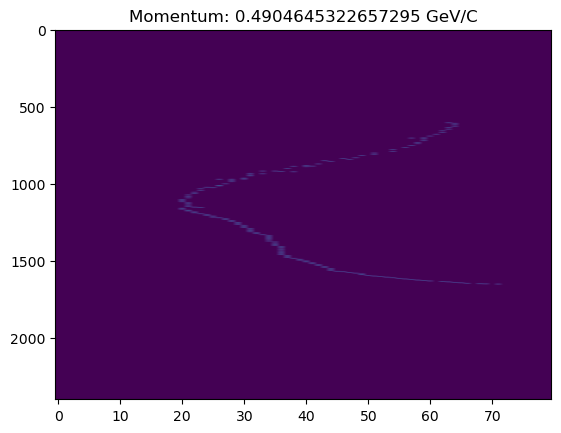

In [28]:
import matplotlib.pyplot as plt
plt.imshow(dataX[5], aspect = "auto")
plt.title("Momentum: {} GeV/C".format(dataY[5]))
plt.show()

In [26]:
# #calculating percent error
# error = np.abs(100*(targets-modeltest)/modeltest)
# error
error_nonabs = 100*(targets-modeltest)/modeltest #for small batch
error_nonabs #for small batch

# error_nonabs = 100*(targets-modeltest)/modeltest #for full batch
# error_nonabs #for full batch

array([-4.72945630e+01, -1.22052648e+01, -5.31836042e+01,  5.91720028e+01,
       -2.18648073e+01, -4.91686642e+00,  4.42980468e+01, -4.59566784e+01,
       -2.73383704e+01, -3.83798027e+01, -4.82004238e+01, -1.83758972e+01,
        8.43536288e+01, -2.02627166e+01, -3.04304807e+01,  7.01724189e+01,
       -2.71694159e+01, -1.33962700e+01,  5.08356735e+01,  1.09218672e+02,
        5.10040072e+01, -1.87860294e+01, -2.23217723e+00, -5.69724550e+01,
       -2.66909300e+01,  4.69031410e+01, -3.72426985e+01, -3.84262953e+01,
       -2.28608284e+01,  6.96938748e+01, -3.95718627e+01,  2.48829843e+01,
       -4.80047896e+01, -6.27719106e+01, -4.18104551e+01,  5.92258952e+01,
        4.18945709e+00,  7.16434988e+00,  4.94172271e+01, -3.49544364e+01,
       -6.95377831e+00,  1.03460609e+02,  1.11244659e+01,  2.00310076e+01,
       -1.88848449e+01, -1.03425193e+01,  9.93854458e+00, -2.36442688e+00,
        2.60305401e+01,  8.04667435e+01, -2.69925567e+01,  7.31993329e+01,
        7.44673708e+00,  

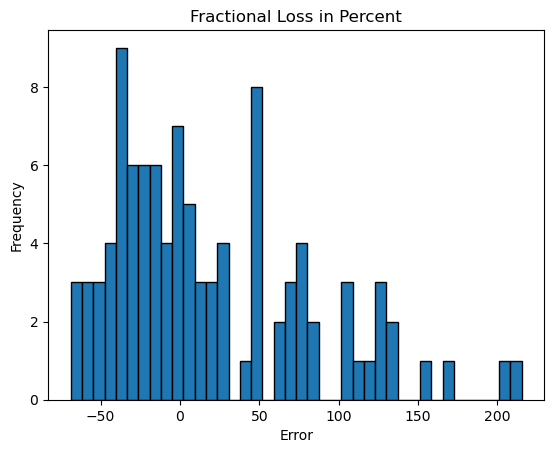

In [27]:
import matplotlib.pyplot as plt
plt.hist(error_nonabs, bins = 40, edgecolor = 'black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Fractional Loss in Percent')
plt.show()

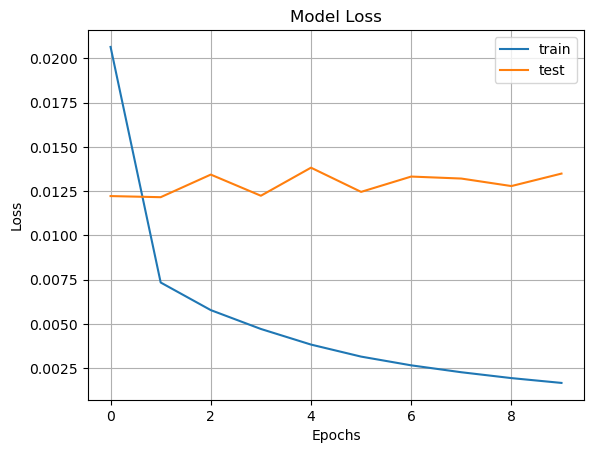

In [28]:
#loss plot
plt.plot(h.history['loss'], label = 'train')
plt.plot(h.history['val_loss'], label = 'test')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.grid()
plt.show()

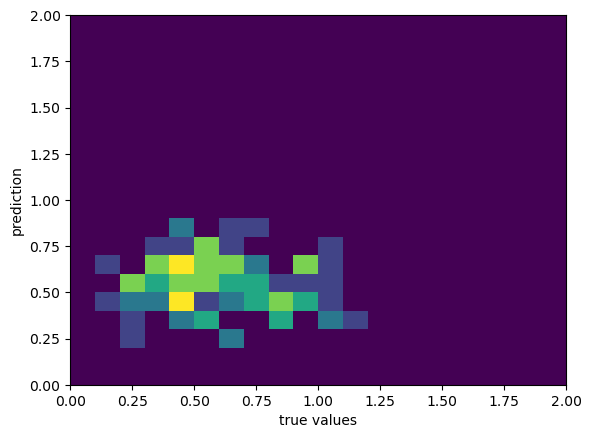

In [30]:
plt.hist2d(targets, modeltest, bins= np.linspace(0, 2, 21))
plt.xlabel("true values")
plt.ylabel("prediction")
plt.show()

In [ ]:
#alpha = 0.01
#four layers on each side of u, one in middle
#activation = linear 
#learning rate = 1e-6
#